# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'after', 'above', "you'd", 'have', 'with', 'further', 'was', 'only', 'don', 'my', 'isn', "aren't", 're', 'are', 'myself', 'they', 'at', "isn't", "mightn't", 'you', 'which', "won't", 't', 'ma', 'that', 'their', 'itself', 'until', 'himself', 'other', 'those', 's', 'yourselves', "she's", 'hers', 'we', 'down', 'having', 'no', 'them', 'now', "hadn't", "didn't", "haven't", 'more', 'and', 'why', 'while', 'same', 'it', 'being', 'been', 'doesn', 'all', 'she', 'in', 've', 'an', 'against', 'too', 'mightn', 'haven', 'if', 'of', 'its', 'the', 'from', 'hasn', 'herself', "shouldn't", "you're", 'again', 'me', 'about', 'theirs', 'does', "mustn't", 'doing', 'your', "wasn't", 'below', 'her', 'then', 'out', 'very', 'by', 'once', 'just', "that'll", 'into', 'this', "wouldn't", 'as', 'during', "couldn't", 'o', 'had', 'to', 'any', "should've", 'these', 'y', "hasn't", 'a', 'when', "weren't", 'shouldn', 'couldn', 'who', 'our', 'here', 'he', 'shan', 'because', 'where', 'but', 'under', 'there', 'yourself', 'off'

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# [7.2.2] Bag of Words (BoW)

In [15]:
final.shape

(364171, 11)

In [16]:
# Considering 250K data samples 

final_60k = final[:250000]

In [17]:
# Sorting data based on time
final_60k["Time"] = pd.to_datetime(final_60k["Time"], unit = "s")
final_60k = final_60k.sort_values(by = "Time")


In [18]:
# 60k data which will use to train model after vectorization

X = final_60k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (250000,)


In [19]:
y = final_60k["Score"]
print("shape of y:", y.shape)

shape of y: (250000,)


In [20]:
# split data into train and test where 70% data used to train model and 30% for test

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42 , shuffle=False)
print(X_train.shape, y_train.shape, x_test.shape)

(175000,) (175000,) (75000,)


In [21]:
# Training using CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer 

abc = CountVectorizer()
X_train = abc.fit_transform(X_train)
X_train

<175000x49171 sparse matrix of type '<class 'numpy.int64'>'
	with 5368283 stored elements in Compressed Sparse Row format>

In [22]:
X_train

<175000x49171 sparse matrix of type '<class 'numpy.int64'>'
	with 5368283 stored elements in Compressed Sparse Row format>

In [23]:
# Test Vectorizor

x_test = abc.transform(x_test)
x_test

<75000x49171 sparse matrix of type '<class 'numpy.int64'>'
	with 2325614 stored elements in Compressed Sparse Row format>

## GradientBoostingClassifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit

In [29]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'max_depth':[10**-2, 10**-1, 1, 10, 10000] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train[:10000])

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train[:10000], y_train[:10000])
gridSearchModel.best_params_


{'max_depth': 10}

In [32]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'n_estimators':[ 1, 10, 10000] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


{'n_estimators': 10000}

In [34]:
classifier = GradientBoostingClassifier(max_depth= 10 , n_estimators = 10000)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 1.0


In [49]:
from sklearn.metrics import f1_score

In [40]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8581066666666667


In [43]:
# Feature importance

pos_feat  = classifier.feature_importances_[:10].argsort()
neg_feat  = classifier.feature_importances_[:10].argsort()

print(np.take(abc.get_feature_names() , neg_feat[:10]))
print(np.take(abc.get_feature_names() , pos_feat[:10]))

['aa' 'aaa' 'aaaa' 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaargh' 'aaaaaaaaagghh' 'aaaaaaarrrrrggghhh' 'aaaaaah'
 'aaaaaahhhhhyaaaaaa' 'aaaaaand']
['aa' 'aaa' 'aaaa' 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaargh' 'aaaaaaaaagghh' 'aaaaaaarrrrrggghhh' 'aaaaaah'
 'aaaaaahhhhhyaaaaaa' 'aaaaaand']


In [53]:
# Function to plot Confusion_Matrix

def Confusion_Matrix(q,w):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 4781  8667]
 [ 1975 59577]]


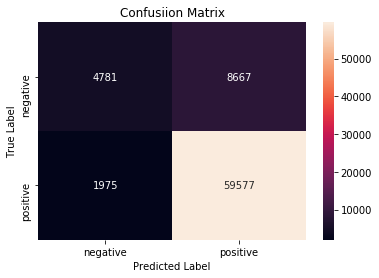

In [46]:
Confusion_Matrix(y_test, pred)

## Random Forest Algo

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = RandomForestClassifier(random_state=0)

grid_parameters = {'max_depth':[10**-2, 10**-1, 1, 10, 100] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


{'max_depth': 100}

In [52]:
classifier = RandomForestClassifier(max_depth= 100)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.9409028571428572


In [53]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8460133333333333


In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 2388 11060]
 [  489 61063]]


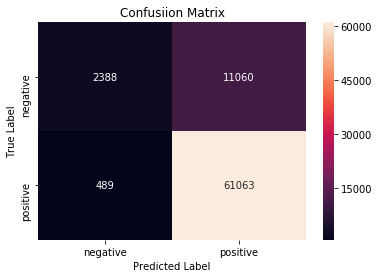

In [55]:
Confusion_Matrix(y_test, pred)

# [7.2.5] TF-IDF

In [16]:
# Considering 250K data samples 

final_60k = final[:250000]

In [17]:
# Sorting data based on time
final_60k["Time"] = pd.to_datetime(final_60k["Time"], unit = "s")
final_60k = final_60k.sort_values(by = "Time")


In [18]:
# Assigning data to X

X = final_60k["CleanedText"]

# Target/class-label

y = final_60k["Score"]

In [19]:
# Spliting the data into train and test such that 70% data will be used to train model and 30% for test purpose.

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)


(175000,) (75000,) (175000,) (75000,)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<175000x1795437 sparse matrix of type '<class 'numpy.float64'>'
	with 11593935 stored elements in Compressed Sparse Row format>

In [21]:
# Convert test text data to its vectorizor

x_test = tf_idf_vect.transform(x_test)
x_test.shape

(75000, 1795437)

## GradientBoostingClassifier

In [ ]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'max_depth':[10**-2, 10**-1, 1, 10, 100] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train[:10000], y_train[:10000])
gridSearchModel.best_params_

In [35]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'n_estimators':[ 1, 10, 10000] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


In [51]:
classifier = GradientBoostingClassifier(max_depth= 10 , n_estimators = 10000)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.8745657142857143


In [52]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy for traning model is 0.8690133333333333


In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 2679  8709]
 [ 1113 62499]]


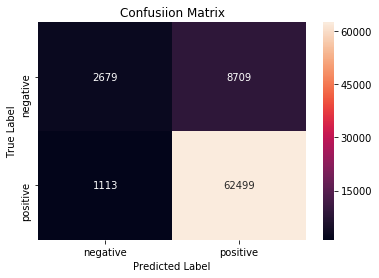

In [55]:
Confusion_Matrix(y_test, pred)

## Random Forest Algo

In [25]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = RandomForestClassifier(random_state=0)

grid_parameters = {'max_depth':[10**-2, 10**-1, 1, 10, 100] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_


{'max_depth': 100}

In [30]:
classifier = RandomForestClassifier(max_depth= 100 , n_estimators = 100)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 0.8628971428571428


In [34]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8508000000000001


In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[  213 11175]
 [   15 63597]]


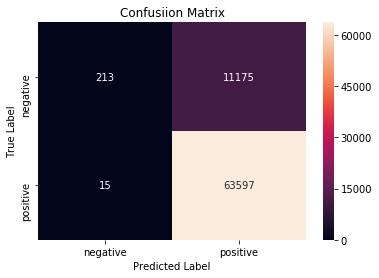

In [38]:
Confusion_Matrix(y_test, pred)

## Avg Word2Vec

In [34]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,shuffle=False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(175000,) (75000,) (175000,) (75000,)


In [35]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [36]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [37]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [38]:
# min_count = 5 considers only words that occured atleast 5 times

w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [39]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

175000
50


In [40]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

75000
50


In [41]:
X_train = sent_vectors
x_test = sent_vectors_test

X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)

In [42]:
x_test = sent_vectors_test

In [43]:
X_train = np.nan_to_num(X_train)

In [44]:
x_test = np.nan_to_num(x_test)

### GradientBoostingClassifier

In [59]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'max_depth':[1, 10, 100] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train, y_train)
gridSearchModel.best_params_

{'max_depth': 10}

In [62]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'n_estimators':[ 1, 10, 10000] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train[:10000])

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train[:10000], y_train[:10000])
gridSearchModel.best_params_


{'n_estimators': 10000}

In [57]:
classifier = GradientBoostingClassifier(max_depth= 10 , n_estimators = 10000)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 1.0


In [63]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.85852


In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 3979  9469]
 [ 1142 60410]]


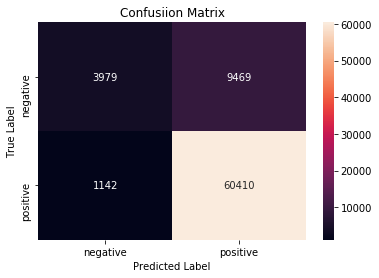

In [65]:
Confusion_Matrix(y_test, pred)

## Random Forest Algo

In [45]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = RandomForestClassifier(random_state=0)

grid_parameters = {'max_depth':[1, 10, 100] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train[:10000])

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train[:10000], y_train[:10000])
gridSearchModel.best_params_


{'max_depth': 10}

In [47]:
classifier = RandomForestClassifier(max_depth= 100 , n_estimators = 100)
classifier.fit(X_train[:10000], y_train[:10000])
tr_score = classifier.score(X_train[:10000], y_train[:10000])
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 1.0


In [50]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8497066666666667


In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 2695 10753]
 [  519 61033]]


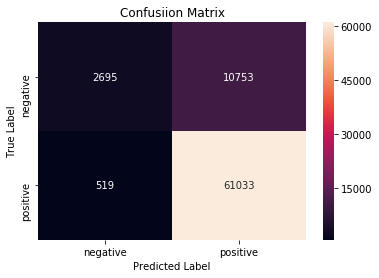

In [54]:
Confusion_Matrix(y_test, pred)

## Avg W2V, TFIDF-W2V

In [ ]:
X_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.3)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

In [ ]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [ ]:
X_train = tfidf_sent_vectors

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [ ]:
x_test = tfidf_sent_vectors_test

In [ ]:
X_train = np.nan_to_num(X_train)

In [ ]:
x_test = np.nan_to_num(x_test)

## GradientBoostingClassifier

In [56]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'max_depth':[1, 10, 100] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train[:10000])

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train[:10000], y_train[:10000])
gridSearchModel.best_params_

{'max_depth': 10}

In [57]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = GradientBoostingClassifier(random_state=0)

grid_parameters = {'n_estimators':[ 1, 10, 10000] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train[:10000])

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train[:10000], y_train[:10000])
gridSearchModel.best_params_


{'n_estimators': 10000}

In [59]:
classifier = GradientBoostingClassifier(max_depth= 10 , n_estimators = 10000)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 1.0


In [60]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8635733333333333


In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 4351  9097]
 [ 1135 60417]]


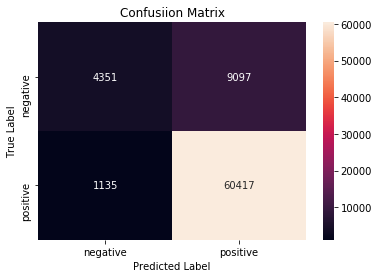

In [62]:
Confusion_Matrix(y_test, pred)

## Random Forest Algo

In [63]:
# training the GradientBoostingClassifier model , getting the best parameter

dtree = RandomForestClassifier(random_state=0)

grid_parameters = {'max_depth':[1, 10, 100] }

my_cv = TimeSeriesSplit(n_splits=2).split(X_train[:10000])

gridSearchModel = GridSearchCV(dtree, grid_parameters, cv=my_cv)
gridSearchModel.fit(X_train[:10000], y_train[:10000])
gridSearchModel.best_params_


{'max_depth': 10}

In [64]:
classifier = RandomForestClassifier(max_depth= 100 , n_estimators = 100)
classifier.fit(X_train, y_train)
tr_score = classifier.score(X_train, y_train)
print('Accuracy for traning model is', tr_score)

Accuracy for traning model is 1.0


In [65]:
pred = classifier.predict(x_test)

accuracy = f1_score(y_test, pred , average = 'micro')
print ('Accuracy on test data is ',accuracy)

Accuracy on test data is  0.8478133333333333


In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)

[[ 2537 10911]
 [  503 61049]]


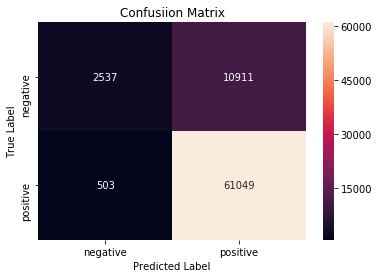

In [67]:
Confusion_Matrix(y_test, pred)

In [26]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Method", " Algorithms " ,  "Accuracy"]

x.add_row(["BOG", 'GradientBoostingClassifier',  '0.858106'])
x.add_row(["BOG", 'Random Forest', '0.846013'])

x.add_row(["TFIDF", 'GradientBoostingClassifier ',   '0.861016'])
x.add_row(["TFIDF", ' Random Forest','0.850800'])

x.add_row(["W2V",'GradientBoostingClassifier' , '0.858521'])
x.add_row(["W2V",'Random Forest' ,'0.849706'])

x.add_row(["TFIDF - W2V",'GradientBoostingClassifier' ,  '0.863557'])
x.add_row(["TFIDF - W2V",'Random Forest' , '0.847813'])


print(x)

+-------------+-----------------------------+----------+
|    Method   |          Algorithms         | Accuracy |
+-------------+-----------------------------+----------+
|     BOG     |  GradientBoostingClassifier | 0.858106 |
|     BOG     |        Random Forest        | 0.846013 |
|    TFIDF    | GradientBoostingClassifier  | 0.861016 |
|    TFIDF    |         Random Forest       | 0.850800 |
|     W2V     |  GradientBoostingClassifier | 0.858521 |
|     W2V     |        Random Forest        | 0.849706 |
| TFIDF - W2V |  GradientBoostingClassifier | 0.863557 |
| TFIDF - W2V |        Random Forest        | 0.847813 |
+-------------+-----------------------------+----------+


# Observations : - 


#### All of the above results with different technique of BOG, TFIDF,W2V, TFIDF-W2v varys with GridSearchCV for GBDT and RF Algorithm  algorithm. Out of all of , TFIDF-W2V gives us highest accuracy of aprox 86.35%